# Text Classification

#### Have you ever wondered how your email filters out <font color=red>spam</font> messages? If yes, then you are about to find out how and implement the solution by yourselves. It is primarily text classification problem.

<img src="../../Images/spam_filtering.png" alt="Drawing" style="width: 150px;"/>

## Table of content:
-  Introduction
-  Import library
-  Load dataset
-  Explore the dataset
-  Pre-processing the text data
-  Feature Engineering
  - Feature Creation
  - Feature evaluation
-  Split into train/test
-  Text to Features
  - Bag of words
  - TF-IDF
  - Word embedding
-  Machine Learning Classifiers
  - Random Forest model
-  Cross - validation
-  Grid-search
-  Model selection and evaluation

## Introduction
In this tutorial, we'll cover some basics of natural language processing like reading in and creating structure in messy text data, and then cleaning and tokenizing that data. Then we'll cover some of the more advanced topics like lemmatizing and vectorizing your data. In other words, converting it from text into a numeric matrix. We'll do this with a focus on preparing our data to build a machine learning classifier on top of it. We'll learn how to build machine learning classifier, while thoroughly testing and evaluating different variations of the model. You'll have the tools to go from messy dataset to concise and accurate predictions from machine learning model, to deliver solutions to complex business problems.

## Import library

Python provides developers with extensive libraries that handle many NLP-related tasks.

In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
import string
import json
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
import time

## Load dataset

In [2]:
pd.set_option('display.max_colwidth', 100)

fullCorpus = pd.read_csv("spam.csv", encoding='latin')
fullCorpus.dropna(axis=1, inplace=True)
fullCorpus.columns = ['label', 'body_text']

fullCorpus.head()

,label,body_text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


## Explore the dataset

Even the well curated data sets can have human errors, and it's vital that we spot quirks with the data and fix/remove them before investing too much time in our analysis.

In [3]:
# What is the shape of the dataset?
print("Input data has {} rows and {} columns".format(len(fullCorpus), len(fullCorpus.columns)))

Input data has 5572 rows and 2 columns


In [4]:
# How many spam/ham are there?
print("Out of {} rows, {} are spam, {} are ham".format(len(fullCorpus),
                                                       len(fullCorpus[fullCorpus['label']=='spam']),
                                                       len(fullCorpus[fullCorpus['label']=='ham'])))

Out of 5572 rows, 747 are spam, 4825 are ham


In [5]:
# How much missing data is there?
print("Number of null in label: {}".format(fullCorpus['label'].isnull().sum()))
print("Number of null in text: {}".format(fullCorpus['body_text'].isnull().sum()))

Number of null in label: 0
Number of null in text: 0


## Pre-processing text data

Text can come in a variety of forms from a list of individual words, to sentences to multiple paragraphs with special characters (like tweets for example). This step is very important in pipeline which helps to feed right data to the model. Generally this steps involve **cleaning**, **lowercasing**, **stemming/lemmatization**, **stop-word removal**, **normalization**.

In [6]:
split_pattern = re.compile(r'\s+')
lemma = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [8]:
#### Normalization
## Contraction dictionary is stored in JSON file as Python dictionary
contractions_data=open("../../utils/contractions.json", encoding="utf8").read()
contractions = json.loads(contractions_data)

p_space = re.compile(r'[^\x20-\x7e]')

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2",
                 "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '”': '"', '“': '"', "£": "e",
                 '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta',
                 '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

puncts = list(string.punctuation)
puncts.extend([',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
    '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
    '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
    '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ' '])

puncts = "".join(puncts)

In [9]:
def clean_text(doc):

    doc = doc.lower()                                          ## Lower casing
    
    # Clean invisible chars
    doc = p_space.sub(r'', doc)                                ## Cleaning - Invisible character

    ## Expanding contraction
    for key, value in contractions.items() :                   ## Normalization
        if key in doc :
            doc = re.sub(r'\b'+key+r'\b',value,doc)

    # Mapping punctuations
    for punct in punct_mapping:                                ## Normalization
        if punct in doc:
            doc = doc.replace(punct, punct_mapping[punct])

    token = split_pattern.split(doc)                           ## Word tokenization

    ## Removing leading and trailing special characters        ## Cleaning
    token = [str1.strip(puncts) for str1 in token]
    token = [str1.lstrip(puncts) for str1 in token]

    ## Removing stop words
    token = [i for i in token if i not in stopwords]           ## Cleaning - Stop words

    ## Converting word to it's lemma
    token = [lemma.lemmatize(word) for word in token]          ## Lemmatization
    
    return token

In [10]:
fullCorpus['body_text_cleaned'] = fullCorpus['body_text'].progress_apply(lambda x: " ".join(clean_text(x)))

100%|████████████████████████████████████████████████████████████████████████████| 5572/5572 [00:03<00:00, 1437.31it/s]


## Feature Engineering: Feature Creation

Right feature is secret sauce for better ML model which influence the results. Using domain knowledge of the data to create more features is feature engineering. Will consider character length of email and count number of punctuation used in email as a feature. Check below pinned article for more information. Check this __[article](https://medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a)__ to understand feature engineering for ML and kaggle __[kernel](https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering)__ on Extensive feature engineering for text data.
> #### Feature engineering is an art.

In [11]:
### Create feature for text message length
fullCorpus['body_len'] = fullCorpus['body_text'].apply(lambda x: len(x) - x.count(" "))

### Create feature for % of text that is punctuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

fullCorpus['punct%'] = fullCorpus['body_text'].apply(lambda x: count_punct(x))

fullCorpus.head()

,label,body_text,body_text_cleaned,body_len,punct%
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go jurong point crazy available bugis n great world la e buffet cine got amore wat,92,9.8
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question(...,128,4.7
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,39,15.4
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though,49,4.1


## Feature evaluation

Moderation is the key to <s>success</s> great Machine learning model. Even though we can come up with more feature but only  relevant feature will really help the model in the learning process. Hence evaluate your feature set and keep only those which shows best result.

Generally spam mails are longer in length and might have very frequent use of punctuation or upper cased words. Let's find out by plotting new feature as a histogram.

c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


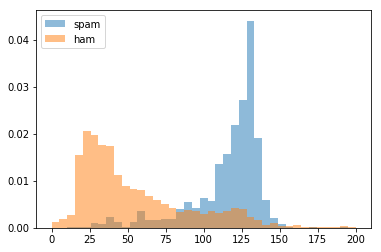

In [12]:
bins = np.linspace(0, 200, 40)

pyplot.hist(fullCorpus[fullCorpus['label']=='spam']['body_len'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(fullCorpus[fullCorpus['label']=='ham']['body_len'], bins, alpha=0.5, normed=True, label='ham')
pyplot.legend(loc='upper left')
pyplot.show()

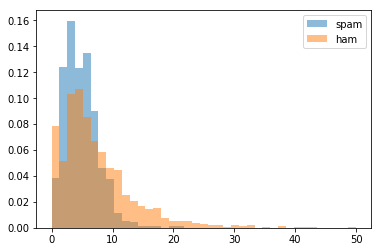

In [13]:
bins = np.linspace(0, 50, 40)

pyplot.hist(fullCorpus[fullCorpus['label']=='spam']['punct%'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(fullCorpus[fullCorpus['label']=='ham']['punct%'], bins, alpha=0.5, normed=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

As thought spam emails are clearly longer in length. However, our hypothesis that spam emails contain more punctuation doesn't appear to be accurate, and it isn't quite clear whether this feature will provide value to the model. Now, in cases like this where there is some separation between the distributions, typically we'll err on the side of leaving this feature in the model just to see what kind of value the model itself may be able to extract out of it. So this is an example of how you might evaluate whether some newly created features will be useful to the model.

## Split into train/test

Training dataset is the subset of dataset to train the model and test dataset is the subset to test the trained model.

Make sure that test set is large enough to yield statistically meaningful results and don't pick a test set with different characteristics than the training set. Assuming that your test set meets the preceding two conditions, your goal is to create a model that generalizes well to new data. Check __[this](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)__ article on spliting data into train and test and why it's required.

In [14]:
# punct% is dropped.
def split_train_test(X,y,test_size=0.2) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test

## Text to Features- Vector representation

Machine learning algorithm can only understand  numeric feature space hence we need to convert input text into a meaningful vector (or array) of numbers. This process is sometime referred as "embedding" or "vectorization". <br>
There are various methods to do the same: Bag of words, TF-IDF, Word2vec.

### Bag of words(Count Vectorization)

The bag-of-words model is a simplifying representation used in NLP. In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

In [15]:
count = CountVectorizer(ngram_range=(1,1))
count_vect = count.fit_transform(fullCorpus['body_text_cleaned'])

X_count_feature = pd.concat([fullCorpus[['body_len']].reset_index(drop=True), pd.DataFrame(count_vect.toarray())], axis=1)

### TF-IDF

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used as features in ML algorithms. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

In [16]:
tfidf = TfidfVectorizer(analyzer=clean_text)
tfidf_vect = tfidf.fit_transform(fullCorpus['body_text_cleaned'])

X_tfidf_feature = pd.concat([fullCorpus[['body_len']].reset_index(drop=True), pd.DataFrame(tfidf_vect.toarray())], axis=1)

# Machine Learning Classifiers

There are many moving parts in a Machine Learning (ML) model that have to be tied together for an ML model to execute and produce results successfully. This process of tying together different pieces of the ML process is known as a pipeline.<br>
https://dzone.com/articles/how-to-build-a-simple-machine-learning-pipeline

In [17]:
def train_model(classifier, X_feature, y_feature, test_size):
    X_train, X_test, y_train, y_test = split_train_test(X_feature, y_feature, test_size)
    
    # fit the training dataset on the classifier
    classifier.fit(X_train, y_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(X_test)

    return metrics.accuracy_score(predictions, y_test)

### Random Forest model
Fortunately, with libraries such as __[Scikit-Learn](https://scikit-learn.org/stable/)__, it’s now easy to implement __[hundreds of machine learning algorithms](https://scikit-learn.org/stable/supervised_learning.html)__ in Python. It’s so easy that we often don’t need any underlying knowledge of how the model works in order to use it. While knowing all the details is not necessary, it’s still helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models. Check this simple __[explanation](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)__ of random forest.

In [18]:
print("Random Forest Classifier using count vectorizer as feature")
train_model(classifier=RandomForestClassifier(n_jobs=-1), 
            X_feature=X_count_feature, 
            y_feature=fullCorpus['label'],
            test_size=0.2)

Random Forest Classifier using count vectorizer as feature


c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9748878923766816

In [19]:
print("Random Forest Classifier using TF-IDF as feature")
train_model(classifier=RandomForestClassifier(n_jobs=-1), 
            X_feature=X_tfidf_feature, 
            y_feature=fullCorpus['label'],
            test_size=0.2)

Random Forest Classifier using TF-IDF as feature


c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9748878923766816

## Cross - validation

You need some kind of assurance that your model has got most of the patterns from the data correct, and its not picking up too much on the noise, or in other words its low on bias and variance. Find more about cross validation __[here](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f)__.

In [20]:
def cross_validation (classifier, X_feature, y_feature, n_splits=5) :
    k_fold = KFold(n_splits=n_splits)
    return cross_val_score(classifier, X_feature, y_feature, cv=k_fold, scoring='accuracy', n_jobs=-1)

In [21]:
print("Random Forest Classifier")
cross_validation(classifier=RandomForestClassifier(n_jobs=-1), 
            X_feature=X_count_feature,   
            y_feature=fullCorpus['label'],
            n_splits=5)

Random Forest Classifier


array([0.97130045, 0.97578475, 0.97396768, 0.96229803, 0.97755835])

In [22]:
print("Random Forest Classifier")
cross_validation(classifier=RandomForestClassifier(n_jobs=-1), 
            X_feature=X_tfidf_feature,
            y_feature=fullCorpus['label'],
            n_splits=5)

Random Forest Classifier


array([0.96950673, 0.97309417, 0.96947935, 0.95601436, 0.96319569])

Cross validation results seems good. 5 fold cross validation accuracy is not varying much which is good sign. It means model is generalizing well from the training data.

## Grid-search

ML/DL hyperparamater tuning is like setting right frequncy of an radio channel to listen noise free audio. Similary grid-search is a method to find the best combination of hyper-parameters (an example of an hyper-parameter is the learning rate of the optimiser), for a given model (e.g. a CNN) and test dataset. Check __[this](https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568)__ article on understanding hyperparameters and it's optimisation techniques.

In [23]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_count_feature, fullCorpus['label'])            ## Also try with X_tfidf_feature
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)

c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,44.049026,0.960341,0.352845,0.021502,None,300,"{'max_depth': None, 'n_estimators': 300}",0.978475,0.976682,0.977558,...,0.977207,0.002383,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
10,22.543966,0.567374,0.213814,0.005129,None,150,"{'max_depth': None, 'n_estimators': 150}",0.981166,0.977578,0.976661,...,0.976669,0.003167,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,38.558354,0.454792,0.342384,0.010566,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.979372,0.977578,0.974865,...,0.976131,0.003247,3,0.999551,0.999103,0.999327,0.999327,0.999103,0.999282,0.000168
7,20.690266,1.028941,0.184013,0.011682,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.978475,0.975785,0.973968,...,0.975772,0.001509,4,0.999327,0.999103,0.999103,0.999327,0.999103,0.999192,0.000110
4,15.123855,1.057890,0.156797,0.020202,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.978475,0.973991,0.972172,...,0.975233,0.002385,5,0.994166,0.993045,0.994841,0.996411,0.994168,0.994526,0.001105
6,2.080525,0.086314,0.067458,0.002273,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.982063,0.971300,0.974865,...,0.974874,0.004135,6,0.998205,0.998205,0.998205,0.998430,0.996635,0.997936,0.000656
3,1.775573,0.027399,0.068802,0.001491,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.973991,0.977578,0.973968,...,0.974336,0.004839,7,0.992596,0.993269,0.995289,0.991925,0.995514,0.993719,0.001440
5,29.947295,1.452509,0.307038,0.013565,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.976682,0.973991,0.973070,...,0.973798,0.003475,8,0.994840,0.993942,0.995514,0.994616,0.994616,0.994706,0.000504
9,2.211782,0.084800,0.071574,0.004143,None,10,"{'max_depth': None, 'n_estimators': 10}",0.973991,0.973094,0.971275,...,0.970747,0.002709,9,0.996410,0.996410,0.997533,0.996635,0.996411,0.996680,0.000435
1,8.788071,0.247401,0.133041,0.008404,30,150,"{'max_depth': 30, 'n_estimators': 150}",0.971300,0.968610,0.964093,...,0.965901,0.003985,10,0.977788,0.977563,0.977120,0.978241,0.976671,0.977477,0.000541


>Mean values in above table is the average value for each set of parameters across all the folds. For instance if you have 10 folds in your CV then mean_score_time will be the average prediction time across the 10 folds. There is obviously some variation across each fold which is indicated by standard deviation(std) where you can use std_score_time to get an idea for how those values vary around that mean value. <br><br>

## Model selection

The above table is sorted based on **mean_test_score** which has mean training time(mean_fit_time) of ~23 sec which is very high campared to ~0.81 sec(row with index number 0) because of low complexity of model ({'max_depth': 30, 'n_estimators': 10}) but it also has least accuracy compared to others. <br><br>
We might be tempted to choose the model with best accuracy but other parameter like training time, inference time(prediction or score time), memory usage etc also plays important role in deciding the final model.<br><br>
We choose the model(index id 3) which has acceptable training and inference time without comprising accuracy.

## Evaluation metric

Evaluating your machine learning algorithm is an essential part of any project. There are various kind of metrics to evaluate our models. Check __[here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)__ why accuracy is not the right evaluation metric. Check this __[article](https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428)__ or __[video](https://www.coursera.org/lecture/machine-learning-with-python/evaluation-metrics-in-classification-5iCQt)__ on evaluation metrics in classification.

## Final step

Once we have decided on features, vectorization methods, hyperparameter values etc. Will put all pieces together and create final model.

In [24]:
rf = RandomForestClassifier(n_estimators=10, max_depth=90, n_jobs=-1)

X_train, X_test, y_train, y_test = split_train_test(X_count_feature, fullCorpus['label'], 0.2)

start = time.time()
rf_model = rf.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 0.673 / Predict time: 0.177 ---- Precision: 0.973 / Recall: 0.862 / Accuracy: 0.976


> **This tutorial is intended to be a public resource. As such, if you see any glaring inaccuracies or if a critical topic is missing, please feel free to point it out or (preferably) submit a pull request to improve the notebook. Also, we are always looking to improve the scope of this article. For anything feel free to mail us @ yogesh.kothiya.101@gmail.com**

> **Author of this article is Yogesh Kothiya. You can follow him on __[LinkedIn](https://www.linkedin.com/in/yogeshkothiya/)__, __[Medium](https://medium.com/@kothiya.yogesh)__, __[GitHub](https://github.com/kothiyayogesh)__, __[Twitter](https://twitter.com/Yogesh_Kothiya)__.**